In [1]:
# Create 2-D gaussians example dataset with class imbalance
import matplotlib.pyplot as plt
import numpy as np

# Gaussian A
mean_A = [0.5, 0.5]
cov_A = [[1,0], [0,2]]

# Gaussian B
mean_B = [-2.5, 0.5]
cov_B = [[2,0], [0,1]]


In [2]:
# Stage-1 training data
x_A, y_A = np.random.multivariate_normal(mean_A, cov_A, 1000).T
x_B, y_B = np.random.multivariate_normal(mean_B, cov_B, 50).T

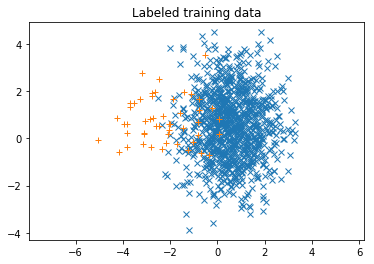

In [21]:
plt.plot(x_A, y_A, 'x')
plt.plot(x_B, y_B, '+')
plt.axis('equal')
plt.title('Labeled training data')
plt.show()

In [4]:
feat_A = np.hstack((x_A[:,np.newaxis], y_A[:,np.newaxis]))
feat_B = np.hstack((x_B[:,np.newaxis], y_B[:,np.newaxis]))
label_A = -np.ones(feat_A.shape[0])
label_B = np.ones(feat_B.shape[0])

print feat_A.shape
print feat_B.shape

X = np.vstack((feat_A, feat_B))
y = np.concatenate((label_A, label_B))
print X.shape
print y.shape



(1000, 2)
(50, 2)
(1050, 2)
(1050,)


In [5]:
from sklearn.svm import LinearSVC
model = LinearSVC(random_state=0, loss='hinge', verbose=1)


In [7]:
# Fit model to stage-1 training data
model.fit(X,y)

[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=0, tol=0.0001, verbose=1)

In [8]:
# Performance on training data
model.score(X,y)

0.97523809523809524

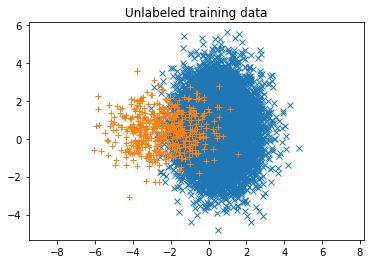

In [22]:
# Generate more data (10x more than labeled training)

# Stage-2 unlabeled data
x_A_s, y_A_s = np.random.multivariate_normal(mean_A, cov_A, 10000).T
x_B_s, y_B_s = np.random.multivariate_normal(mean_B, cov_B, 500).T

X_semi = np.vstack((np.hstack((x_A_s[:,np.newaxis], y_A_s[:,np.newaxis])),
          np.hstack((x_B_s[:,np.newaxis], y_B_s[:,np.newaxis]))))


X_semi.shape

plt.plot(x_A_s, y_A_s, 'x')
plt.plot(x_B_s, y_B_s, '+')
plt.axis('equal')
plt.title('Unlabeled training data')
plt.show()


In [23]:
# Predict labels for unlabeled data
preds = model.predict(X_semi)  # y_hat
print preds.shape

(10500,)


In [28]:
# Semi-supervised learning: 
#   train on the generated labels on unlabeled data AND labeled dataset
model_semi = LinearSVC(random_state=0, loss='hinge', verbose=1)

# Stage-2 training: originalData + noisyData
X_new = np.vstack((X, X_semi))
print X_new.shape
y_new = np.concatenate((y, preds))
print y_new.shape

model_semi.fit(X_new, y_new)

(11550, 2)
(11550,)
[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=0, tol=0.0001, verbose=1)

In [29]:
# Compare the performance of the two models

# Generate test-set:
x_A_test, y_A_test = np.random.multivariate_normal(mean_A, cov_A, 10000).T
x_B_test, y_B_test = np.random.multivariate_normal(mean_B, cov_B, 500).T

X_test = np.vstack((np.hstack((x_A_test[:,np.newaxis], y_A_test[:,np.newaxis])),
          np.hstack((x_B_test[:,np.newaxis], y_B_test[:,np.newaxis]))))
y_test = np.concatenate((-np.ones(x_A_test.shape[0]),
                          np.ones(x_B_test.shape[0])))


print X_test.shape 
print y_test.shape

(10500, 2)
(10500,)


In [26]:
#
y_hat = model.predict(X_test)
y_hat_semi = model_semi.predict(X_test)

score = model.score(X_test, y_test)
score_semi = model_semi.score(X_test, y_test)

In [27]:
print score
print score_semi

0.979619047619
0.979619047619
